<a href="https://colab.research.google.com/github/albertomariapepe/Learning-Rotations/blob/main/Learning_Bivectors_from_Rotors_5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pygae/clifford.git@master

In [ ]:
!pip install tensorflow_graphics

KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='dense_27/BiasAdd:0', description="created by layer 'dense_27'")
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 38,538
Trainable params: 38,538
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
733/733 [==============================] - 3s 3ms/step - loss: 0.9941 - val_loss: 0.1348
Epoch 2/100
733/733 [==============================] - 2s 3ms/step - loss: 0.1000 - val_loss: 0.0341
Epoch 3/100
733/733 [==============================] - 2s 3ms/step - loss: 0.0321 - val_loss: 0.0185
Epoch 4/100
733/733 [==============================] - 2s 3ms/step - loss: 0.0220 - val_loss: 0.0146
Epoch 5/100
733/733 [==============================] - 2s 3ms/step - loss: 0.0158 - val_loss: 0.0119
Epoch 6/100
733/733 [==============================] - 2s 3

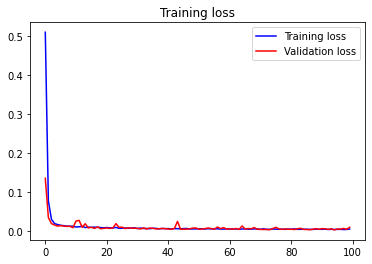

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: DeprecationWarning: Treating MultiVector objects like a sequence is deprecated. To access the coefficients as a sequence, use the `.value` attribute.


54.618562344033315
3.9913347130932055
2.5157341478309942


In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np
from clifford.g3c import *
from clifford.tools.g3c import *
from clifford.tools.g3c.rotor_parameterisation import *
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from keras import backend as K
from sklearn.model_selection import train_test_split
from math import acos
import tensorflow as tf
from matplotlib import pyplot as plt
import keras
from math import e, pi
import tensorflow_graphics as tfg
import tensorflow_graphics.geometry.transformation as tfg_transformation

tot = int(1e5)
'''
#GENERATING THE RANDOM DATASET
i = 0

rot = []
b = []


for i in range(0,tot):

    R = random_rotation_translation_rotor()

    r = []
    for i in range(0,32):
        r = np.append(r, R[i])
    
    rot = np.append(rot, r)

    B = (1 - R)/(1+R)
    bi = []
    for i in range(6,16):
        bi = np.append(bi, B[i])
    
    #print(bi)
    b = np.append(b, bi)


np.save('Bivectors_cayley-5D.npy', b)
np.save('Rotors-5D.npy', rot)
'''

rot = np.load('Rotors-5D.npy')
b = np.load('Bivectors_cayley-5D.npy')

#rot = np.load('Rotors.npy')
#b = np.load('Bivectors_cayley.npy')

rot = np.reshape(rot, [tot, 32])
b = np.reshape(b, [tot, 10])

#Train - Test Split
r_train, r_test = train_test_split(rot, test_size=0.33, shuffle=False)
b_train, b_test = train_test_split(b, test_size=0.33, shuffle=False)


TRAIN = b_train
TEST = b_test
out_size = 10

nb_epoch = 100
batch_size = 64


r_input = Input(shape=(32))
x = Dense(128)(r_input)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.2)(x)
out = Dense(out_size)(x)
print(out)


model = keras.Model(r_input,  out)
model.summary()
model.compile(loss='mse', optimizer="adam")
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_train = model.fit(x = r_train, y = TRAIN, 
                        validation_split=0.3,
                        epochs=nb_epoch,
                        verbose=1,
                        batch_size=batch_size)



loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(nb_epoch)
plt.figure()
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

predicted = model.predict(r_test)

M = []
Langle = []

for i in range(0,int(tot*0.33)):
    B = predicted[i][0]*e12 +predicted[i][1]*e13 + predicted[i][2]*e14+ predicted[i][3]*e15 +predicted[i][4]*e23 + predicted[i][5]*e24+predicted[i][6]*e25 +predicted[i][7]*e34 + predicted[i][8]*e35+predicted[i][9]*e45
    #Rot_pred = e**(-B/2)

    Rot_pred = (1-B)/(1+B)       
    
    #print(Rot_pred)
    B = TEST[i][0]*e12 +TEST[i][1]*e13 + TEST[i][2]*e14+ TEST[i][3]*e15+TEST[i][4]*e23 +TEST[i][5]*e24 + TEST[i][6]*e25+ TEST[i][7]*e34+TEST[i][8]*e35 +TEST[i][9]*e45

    #Rot_real = e**(-B/2)
    Rot_real = (1-B)/(1+B) 

    #print(Rot_real)

    #print(Rot_real*~Rot_pred)
    cosine = (Rot_real*~Rot_pred)[0]
    #print(cosine)
    #print('-----------------')
    if cosine > 1:
        cosine = 1
    Langle = np.append(Langle, acos(cosine))
    if (acos(cosine)*180/pi) > 90:
        print(acos(cosine)*180/pi)


print(np.max(Langle)*180/pi)
print(np.average(Langle)*180/pi)
print(np.std(Langle)*180/pi)

In [ ]:
M = []
Langle = []

for i in range(0,int(tot*0.33)):
    B = predicted[i][0]*e12 +predicted[i][1]*e13 + predicted[i][2]*e14+ predicted[i][3]*e15 +predicted[i][4]*e23 + predicted[i][5]*e24+predicted[i][6]*e25 +predicted[i][7]*e34 + predicted[i][8]*e35+predicted[i][9]*e45
    #Rot_pred = e**(-B/2)

    Rot_pred = (1-B)/(1+B)       
    
    #print(Rot_pred)
    B = TEST[i][0]*e12 +TEST[i][1]*e13 + TEST[i][2]*e14+ TEST[i][3]*e15+TEST[i][4]*e23 +TEST[i][5]*e24 + TEST[i][6]*e25+ TEST[i][7]*e34+TEST[i][8]*e35 +TEST[i][9]*e45

    #Rot_real = e**(-B/2)
    Rot_real = (1-B)/(1+B) 

    #print(Rot_real)

    #print(Rot_real*~Rot_pred)
    cosine = (Rot_real*~Rot_pred)[0]
    #print(cosine)
    #print('-----------------')
    if cosine > 1:
        cosine = 1
    Langle = np.append(Langle, acos(cosine))
    if (acos(cosine)*180/pi) > 90:
        print(acos(cosine)*180/pi)


print(np.max(Langle)*180/pi)
print(np.average(Langle)*180/pi)
print(np.std(Langle)*180/pi)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Treating MultiVector objects like a sequence is deprecated. To access the coefficients as a sequence, use the `.value` attribute.


69.60563022930515
3.1016152592149475
4.214392054768325
